In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [2]:
img = cv2.imread('example.png')
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

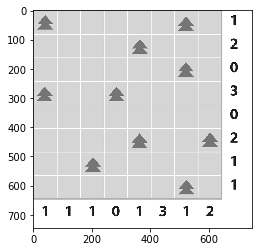

In [3]:
plt.imshow(gray, cmap='gray');

In [4]:
kernel_size = 5
blur_gray = cv2.GaussianBlur(gray,(kernel_size, kernel_size),0)

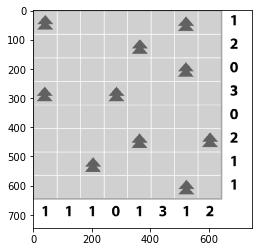

In [5]:
plt.imshow(blur_gray, cmap='gray');

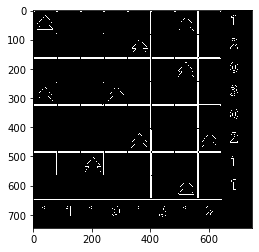

In [6]:
low_threshold = 10
high_threshold = 50
edges = cv2.Canny(blur_gray, low_threshold, high_threshold)
plt.imshow(edges, cmap='gray');

There should be 9 + 9 lines

we find 36 lines


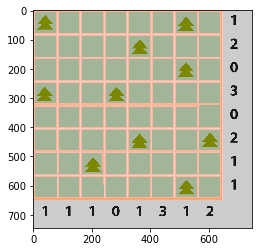

In [58]:
rho = 3  # distance resolution in pixels of the Hough grid
theta = np.pi / 180  # angular resolution in radians of the Hough grid
threshold = 20  # minimum number of votes (intersections in Hough grid cell)
min_line_length = 100  # minimum number of pixels making up a line
max_line_gap = 40  # maximum gap in pixels between connectable line segments
line_image = np.copy(img) * 0  # creating a blank to draw lines on

# Run Hough on edge detected image
# Output "lines" is an array containing endpoints of detected line segments
lines = cv2.HoughLinesP(edges, rho, theta, threshold, np.array([]),
                    min_line_length, max_line_gap)

print(f'we find {len(lines)} lines')

for line in lines:
    for x1,y1,x2,y2 in line:
        cv2.line(line_image,(x1,y1),(x2,y2),(255,0,0),5)
        
# Draw the lines on the  image
lines_edges = cv2.addWeighted(img, 0.8, line_image, 1, 0)
plt.imshow(lines_edges, cmap='gray');

In [59]:
line_size = np.abs((lines[:,0,0]-lines[:,0,2]) + (lines[:,0,1]-lines[:,0,3]))
line_size

array([646, 646, 646, 646, 646, 646, 646, 646, 486, 407, 646, 646, 646,
       646, 646, 647, 486, 645, 633, 646, 637, 637, 637, 637, 637, 637,
       636, 637, 637, 635, 637, 637, 637, 637, 562, 109], dtype=int32)

In [60]:
lines = lines[line_size > 600]
len(lines)

31

In [61]:
lines = lines.reshape(31,2,2)
lines[:2]

array([[[325, 647],
        [325,   1]],

       [[161, 647],
        [161,   1]]], dtype=int32)

In [62]:
count = 0
for line in lines:
    for idx, other_line in enumerate(lines):
        diff = np.abs(np.sum(line-other_line))
#         print(diff)
        if (diff < 15) & (diff != 0):
            count += 1
            print(idx, end=' ')

10 30 12 24 26 18 28 14 15 9 25 6 19 21 5 19 21 20 22 17 29 4 23 25 0 30 13 16 27 1 24 26 11 16 27 3 15 3 14 11 13 27 8 29 2 28 5 6 21 7 22 5 6 19 7 20 9 25 1 12 26 4 9 23 1 12 24 11 13 16 2 18 8 17 0 10 

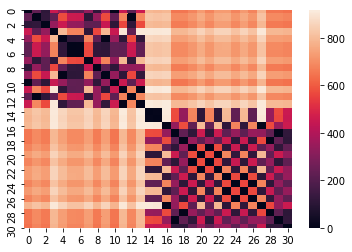

In [63]:
from scipy.spatial import distance_matrix
sns.heatmap(distance_matrix(lines.reshape(-1,4), lines.reshape(-1,4)))

In [64]:
hoi = distance_matrix(lines.reshape(-1,4), lines.reshape(-1,4))

In [65]:
# !conda install seaborn

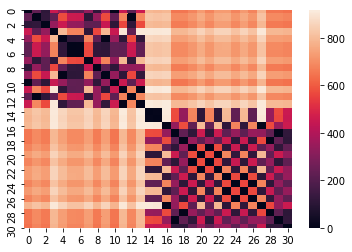

In [66]:
import seaborn as sns
sns.heatmap(hoi)

In [67]:
similar_idx = np.array(np.where(hoi < 100)).T
similar_idx = similar_idx[np.diff(similar_idx, axis=1).reshape(-1) > 0]

In [68]:
# indices to drop
similar_idx = similar_idx[:,1]
similar_idx

array([10, 12,  9,  6, 13, 15, 27, 29, 28, 21, 22, 25, 26], dtype=int64)

In [69]:
lines = np.delete(lines, similar_idx, axis=0)

In [79]:
# Yay! 18 lines!!
len(lines)

18

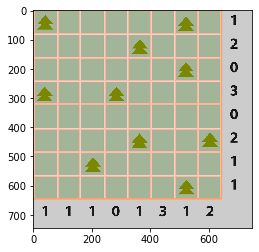

In [81]:
line_image = np.copy(img) * 0

for line in lines.reshape(-1,1,4):
    for x1,y1,x2,y2 in line:
        cv2.line(line_image,(x1,y1),(x2,y2),(255,0,0),5)
        
# Draw the lines on the  image
lines_edges = cv2.addWeighted(img, 0.8, line_image, 1, 0)
plt.imshow(lines_edges, cmap='gray');

In [98]:
np.unique(lines[:,0])

array([  0,   1,   4,   5,   6,  81,  84, 161, 165, 242, 245, 322, 325,
       402, 406, 486, 566, 643, 647], dtype=int32)

In [85]:
np.unique(lines[:,1])

array([  1,   4,  81,  84, 161, 165, 242, 245, 322, 325, 402, 406, 486,
       566, 642, 643, 645, 646, 647], dtype=int32)

In [101]:
hor_lines = lines[np.diff(lines[:,:,0]).reshape(-1) == 0]

In [102]:
ver_lines = lines[np.diff(lines[:,:,1]).reshape(-1) == 0]

In [136]:
def line_intersection(line1, line2):
    xdiff = (line1[0][0] - line1[1][0], line2[0][0] - line2[1][0])
    ydiff = (line1[0][1] - line1[1][1], line2[0][1] - line2[1][1])

    def det(a, b):
        return a[0] * b[1] - a[1] * b[0]

    div = det(xdiff, ydiff)
    if div == 0:
       raise Exception('lines do not intersect')

    d = (det(*line1), det(*line2))
    x = det(d, xdiff) / div
    y = det(d, ydiff) / div
    return np.array([[x, y]])

In [139]:
intersections = np.empty(shape=(1,2))
for hor_line in hor_lines:
    for ver_line in ver_lines:
        intersections = np.append(intersections, line_intersection(hor_line, ver_line),axis=0)
# line_intersection(hor_lines[0], ver_lines[0])

In [147]:
np.sort(intersections, axis=1)[:5]

array([[322., 643.],
       [  1., 325.],
       [325., 647.],
       [325., 406.],
       [242., 325.]])

In [150]:
for intersection in intersections:
    x,y = intersections[5]
    

array([325., 486.])